In [1]:
# reload(cdom_processing)
import cdom_processing
from imp import reload
import numpy as np

img, band_names = cdom_processing.load_S3_image()
img.shape

(2369, 3329, 18)

In [2]:
import matplotlib
matplotlib.__version__

'2.1.0'

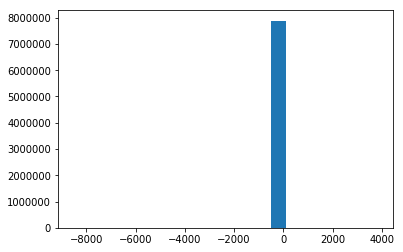

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.hist(img[:,:,17].flatten(),bins=20)

In [4]:
np.min(img[:,:,16]),np.max(img[:,:,16])


(-3542.4685136249209, 1802.380911669238)

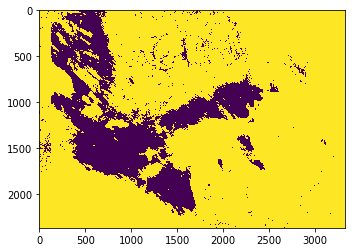

In [5]:
reload(cdom_processing)
mascara = cdom_processing.load_mask()
mascara = (mascara==1)
plt.imshow(mascara)

In [7]:
ratio = np.ma.masked_array(img[:,:,16],mascara)

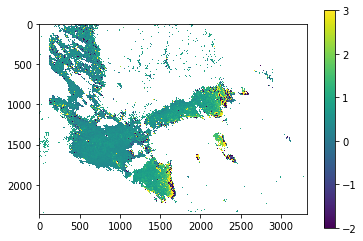

In [8]:
plt.imshow(ratio,vmin=-2,vmax=3)
plt.colorbar()

In [9]:
np.min(img[:,:,0][mascara]),np.max(img[:,:,0][mascara])

(-0.063661978185395526, 0.31831572107435879)

In [9]:
# from scipy import sparse
# S3ratio1 = (img[:,:,7])/(img[:,:,3])
# S3ratio2 = (img[:,:,10])/(img[:,:,3])
# ratios = np.dstack(([S3ratio1, S3ratio2]))
# # print(ratios.shape, img.shape)
# img = np.dstack(([img, ratios]))
# print(img.shape)



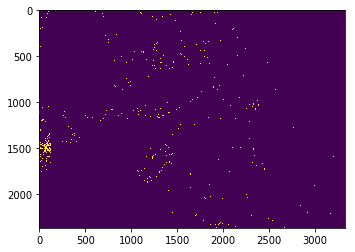

In [10]:
mascara_raros = np.where((img[:,:,0] > .3) & ~mascara, 1 , 0)
plt.imshow(mascara_raros)

In [47]:
import pandas as pd

models = pd.read_csv("/media/ana/Nuevo vol/IPL/Databases/C2X/Chl/tabla_errores_totales_C2AX_Chl.csv")
#tabla_errores_totales_C2AX_TSM
models

,R2,best_params,bias,mae,model,pearsonr,res_abs,rmse_abs,rmse_rel,name_bands
0,0.552733,{'alpha': 0.00066666666666666664},0.021559,5.547687,RLR,0.746836,16.954928,16.954887,12.650056,S3bands
1,0.750773,{'n_estimators': 200},-0.115118,3.198849,RFR,0.866500,12.657923,12.656352,19.085771,S3bands
2,0.730246,"{'alpha': 1.7953321364452423e-07, 'gamma': 0.0...",-0.405313,4.970880,KRR,0.854806,13.185969,13.167268,14.815563,S3bands
3,0.438220,"{'k2': WhiteKernel(noise_level=0.874), 'k1': 9...",-0.894526,4.356055,GPR,0.710930,19.064853,19.001792,3.186989,S3bands
4,0.698451,"{'gamma': 2.1360269013268494, 'C': 1000.0, 'ep...",-1.494725,3.097923,SVR,0.841833,14.160330,13.921650,1.812750,S3bands


In [48]:
reload(cdom_processing)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

relation_name_bands_bands ={"S3ratio2":["S3ratio2"],
                            "S3ratio1": ["S3ratio1"],
                           "S3bands": cdom_processing.bands_S3,
                           "S3bands&ratios":cdom_processing.bands_S3_plus_ratios}

relation_model_name_model ={"KRR":KernelRidge(kernel="rbf"),
                            "RFR": RandomForestRegressor(),
                            "RLR": Ridge(),
                            "SVR": SVR()}
print(relation_name_bands_bands)

{'S3ratio2': ['S3ratio2'], 'S3ratio1': ['S3ratio1'], 'S3bands': ['400', '412.5', '442.5', '490', '510', '560', '620', '665', '673.75', '681.25', '708.75', '753.75', '778.75', '865', '885'], 'S3bands&ratios': ['400', '412.5', '442.5', '490', '510', '560', '620', '665', '673.75', '681.25', '708.75', '753.75', '778.75', '865', '885', 'S3ratio1', 'S3ratio2']}


In [49]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor


In [50]:
###1. Read dataset
reload(cdom_processing)

skdata = cdom_processing.read_data_syke()

skdata.head()

,Unnamed: 0,Unnamed: 0.1,Run_ID,Chl,TSM,a_440_cdom,T,S,theta,phi,...,764.38,767.5,778.75,865,885,900,940,1020,S3ratio1,S3ratio2
0,0,0,20002,1.20,0.00,0.220,25,5,30,60,...,0.000036,0.000035,0.000042,0.000015,0.000012,0.000012,0.000002,1.200000e-06,0.230262,0.128128
5,5,5,20032,2.10,0.08,0.218,20,20,30,15,...,0.000043,0.000040,0.000046,0.000017,0.000015,0.000010,0.000004,2.100000e-06,0.239242,0.131884
9,9,9,20045,0.18,0.08,0.112,30,5,10,45,...,0.000021,0.000020,0.000022,0.000005,0.000008,0.000007,0.000001,7.000000e-07,0.125279,0.061194
13,13,13,20060,0.29,1.30,0.196,15,30,20,45,...,0.000155,0.000155,0.000167,0.000069,0.000058,0.000053,0.000011,1.050000e-05,0.229513,0.121153
16,16,16,20064,0.05,0.02,0.230,0,20,20,30,...,0.000016,0.000015,0.000012,0.000005,0.000006,0.000004,0.000002,0.000000e+00,0.160213,0.079574


In [54]:
from numpy import array

reload(cdom_processing)
indice_modelo = 4

name_bands_syke = models.loc[indice_modelo,
                                  "name_bands"]
bands_syke = relation_name_bands_bands[name_bands_syke]

name_model = models.loc[indice_modelo, "model"]
print("model %s bands: %s"%(name_model,name_bands_syke))

if name_model != "GPR":
    model = relation_model_name_model[name_model]
    params = eval(models.loc[indice_modelo,"best_params"])
    model.set_params(**params)
    print(params)
else:
    params = eval(models.loc[indice_modelo,"best_params"])
    print(params)
    kernel = params["k1"]+params["k2"]
    model = GaussianProcessRegressor(kernel=kernel,optimizer=None,n_restarts_optimizer=0)
    
scaler,y_mean = cdom_processing.load_model(skdata,model,
                                           bands=bands_syke)
model,scaler,y_mean

model SVR bands: S3bands
{'gamma': 2.1360269013268494, 'C': 1000.0, 'epsilon': 0.0010001500225033755}


(SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3,
   epsilon=0.0010001500225033755, gamma=2.1360269013268494, kernel='rbf',
   max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 MinMaxScaler(copy=True, feature_range=(0, 1)),
 3.3475602094240839)

In [17]:
y_mean

3.3475602094240839

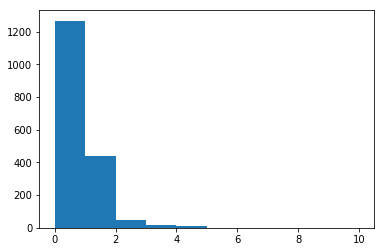

In [31]:
_ = plt.hist(skdata['Chl'])

In [55]:
reload(cdom_processing)
cdom_array = np.asarray(skdata['Chl'])
min_cdom = np.min(cdom_array)
max_cdom = np.max(cdom_array)
predictions = cdom_processing.predict_image(img,band_names,mascara,model,scaler,bands_syke,
                                            y_range=(0,max_cdom),y_mean=y_mean,step=300)

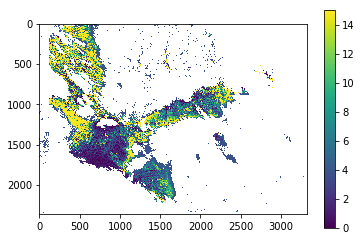

In [56]:
plt.imshow(predictions,vmax=15)
plt.colorbar()

In [29]:
reload(cdom_processing)
if name_model == "GPR":
    predict_function = lambda data: model.predict(data,return_std=True)[1]
    std_predictions = cdom_processing.predict_image(img,band_names,mascara,model,scaler,bands_syke,
                                                   y_range=(0,99999),y_mean=0,step=300,
                                                   predict_function=predict_function)


In [30]:
if name_model == "GPR":
    plt.imshow(std_predictions)
    plt.colorbar()


In [23]:
print("Rango cdom: %.4f %.4f"%(min_cdom,max_cdom))

Rango cdom: 0.0980 20.0000


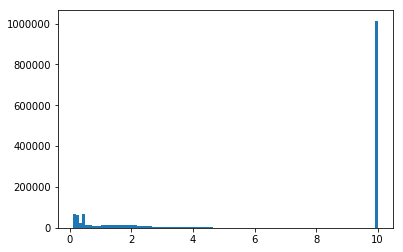

In [44]:
_ = plt.hist(predictions[~np.isnan(predictions)],bins=100)

In [31]:
path = '/media/ana/Nuevo vol/IPL/Databases/'
cdom_processing.write_envi(std_predictions, path + name_model+'_'+name_bands_syke+'_CDOM_C2X_std.hdr')

Saving /media/ana/Nuevo vol/IPL/Databases/RLR_S3bands&ratios_CDOM_C2X_std.img


In [57]:
path = '/media/ana/Nuevo vol/IPL/Databases/'
cdom_processing.write_envi(predictions, path + name_model+'_'+name_bands_syke+'_CHL_C2X.hdr')


Saving /media/ana/Nuevo vol/IPL/Databases/SVR_S3bands_CHL_C2X.img
